<a href="https://colab.research.google.com/github/cometku/SEESMosquitoMappers/blob/master/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, Conv2D, MaxPool2D
from sklearn.metrics import confusion_matrix
from scipy import misc, ndimage

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#we will change these
base_path = input('What is your path to your folders? ')
base_path = os.path.join('/content/gdrive', base_path)
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'testing')

What is your path to your folders? My Drive/plots_AI


In [ ]:
categories = [f.name for f in os.scandir(train_path) if os.path.isdir(f)]
categories

['Water',
 'Cultivated Vegetation',
 'Impervious Surface (No Building)',
 'Trees_Canopycover',
 'Grass',
 'Bush_or_Scrub',
 'Building',
 'Bare Ground']

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=20
)
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=10
)

Found 6661 images belonging to 8 classes.
Found 1325 images belonging to 8 classes.


In [ ]:
# SKIP IF YOU ARE LOADING THE MODEL FROM A FILE
def build_model(input_shape, class_count):

    model = Sequential()

    # layer 1 - "filters the 224 x 224 x 3 input image with 96 kernels
    #           of size 11 x 11 x 3 with a stride of 4 pixels"
    model.add(Conv2D(filters=96,
                                  kernel_size=(11, 11),
                                  strides=4,
                                  input_shape=input_shape,
                                  activation="selu",
                                  padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3),
                                     strides=(2, 2)))

    # layer 2 - "256 kernels of size 5 x 5 x 48"
    model.add(Conv2D(filters=256,
                                  kernel_size=(5, 5),
                                  activation="selu",
                                  padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3),
                                     strides=(2, 2)))

    # layer 3 - "384 kernels of size 3 x 3 x 256"
    model.add(Conv2D(filters=384,
                                  kernel_size=(3, 3),
                                  activation="selu",
                                  padding="same"))
    # layer 4 - "384 kernels of size 3 x 3 x 192"
    model.add(Conv2D(filters=384,
                                  kernel_size=(3, 3),
                                  activation="selu",
                                  padding="same"))
    # layer 5 - "256 kernels of size 3 x 3 x 192"
    model.add(Conv2D(filters=256,
                                  kernel_size=(3, 3),
                                  activation="selu",
                                  padding="same"))
    model.add(MaxPool2D(pool_size=(3, 3),
                                     strides=(2, 2)))

    # flatten before feeding into FC layers
    model.add(Flatten())

    # fully connected layers
    # "The fully-connected layers have 4096 neurons each."
    # "We use dropout in the first two fully-connected layers..."
    model.add(Dense(4096))  # layer 6
    model.add(BatchNormalization())
    model.add(Dense(1024))  # layer 7
    model.add(BatchNormalization())
    model.add(Dense(units=class_count, activation='softmax'))  # layer 8

    return model

In [ ]:
model = build_model((128, 128, 3), len(categories))

In [ ]:
# Choose whether to load the best model or the final model
# I loaded the best one
model = load_model('/content/gdrive/My Drive/AI_CEO/best_alexnet_model2.h5')

In [ ]:
model.compile(Adam(lr=0.000125), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(
    '/content/gdrive/My Drive/AI_CEO/best_alexnet_model2.h5', # Rename or save in a different directory for the second training iteration
    save_best_only=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    factor = 0.25,
    patience = 3,
    min_delta = 0.001,
    verbose = 1
)
early_stop = EarlyStopping(
    min_delta = 0.0005,
    patience = 5,
    verbose = 1
)

In [ ]:
# Recalculate training and testing steps
train_steps = train_batches.samples // train_batches.batch_size
valid_steps = valid_batches.samples // valid_batches.batch_size
print(train_steps)
print(valid_steps)

333
132


In [ ]:
history = model.fit(
    train_batches,
    steps_per_epoch=train_steps,
    validation_data=valid_batches,
    validation_steps=valid_steps,
    epochs=25,
    callbacks = [checkpoint, reduce_lr, early_stop],
    verbose=1
)

Epoch 1/25
333/333 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.7791
Epoch 00001: val_loss improved from inf to 0.61234, saving model to /content/gdrive/My Drive/AI_CEO/best_alexnet_model2.h5
333/333 [==============================] - 421s 1s/step - loss: 0.6331 - accuracy: 0.7791 - val_loss: 0.6123 - val_accuracy: 0.8000 - lr: 1.2500e-04
Epoch 2/25
333/333 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.7905
Epoch 00002: val_loss improved from 0.61234 to 0.56099, saving model to /content/gdrive/My Drive/AI_CEO/best_alexnet_model2.h5
333/333 [==============================] - 431s 1s/step - loss: 0.6053 - accuracy: 0.7905 - val_loss: 0.5610 - val_accuracy: 0.7924 - lr: 1.2500e-04
Epoch 3/25
333/333 [==============================] - ETA: 0s - loss: 0.5838 - accuracy: 0.8015
Epoch 00003: val_loss did not improve from 0.56099
333/333 [==============================] - 375s 1s/step - loss: 0.5838 - accuracy: 0.8015 - val_loss: 0.5964 - va

In [ ]:
model.save('/content/gdrive/My Drive/AI_CEO/final_alexnet_model2.h5')

In [ ]:
import pickle as pkl
with open('/content/gdrive/My Drive/AI_CEO/alexnet_history2', 'wb') as hist:
    pkl.dump(history.history, hist)

In [ ]:
def plot_history(history):

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

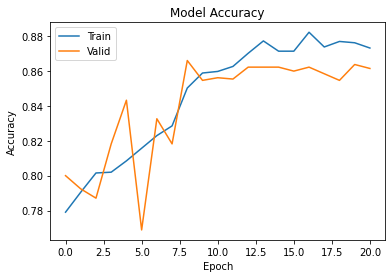

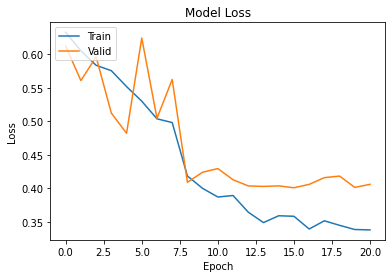

In [ ]:
plot_history(history)

In [ ]:
# Use this if your test directory contains another folder called test, which itself contains the images:
# test_dir/test/images, instead of test_dir/images
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(128, 128),
    classes=['test'],
    batch_size=10
)

Found 891 images belonging to 1 classes.


In [ ]:
x_model = load_model('/content/gdrive/My Drive/Copy of best_xception_model2.h5')

In [ ]:
def test_generator(test_dir, target_size):
    for f in os.scandir(test_dir):
        if os.path.isfile(f):
            im = cv2.imread(f.path)
            yield np.expand_dims(cv2.resize(im, target_size), 0)

In [ ]:
test_batches = test_generator(test_path, (128, 128))

In [ ]:
predictions = x_model.predict(test_batches, verbose=1)

891/891 [==============================] - 94s 106ms/step


In [ ]:
import pandas as pd

csv = pd.read_csv('/content/gdrive/My Drive/plots_AI/test_csv.csv')
cats = csv['category']

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

true = LabelEncoder().fit_transform(cats)

In [ ]:
accuracy_score(true, np.argmax(predictions, 1))

0.3052749719416386

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, np.argmax(predictions, -1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Confusion matrix, without normalization
[[  2  17  15  25   3  20  19  19]
 [  6   8  32   1   0  17   3   1]
 [  5  83   6  11   1   4  36   0]
 [ 24   1   2   1   7  10   5   0]
 [  5   0   3   0  13   7   2   0]
 [  4   2  14   1   5  94   3   0]
 [  7  15   3  14   0   9 141   0]
 [ 24   4   0 116   0   6   8   7]]


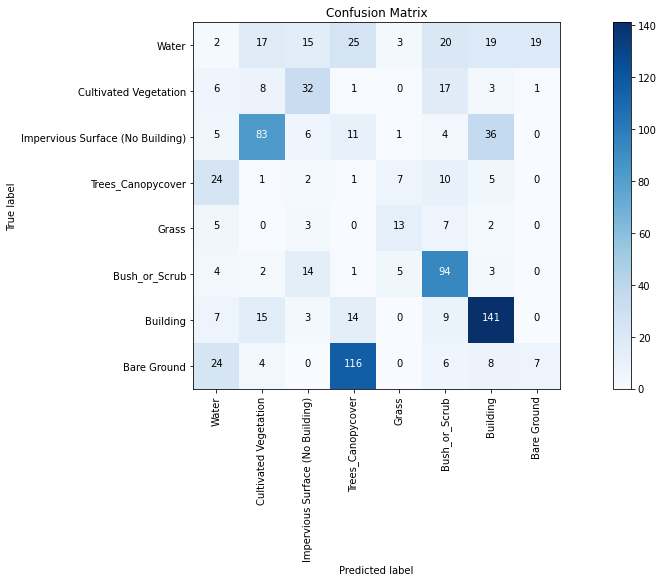

In [ ]:
plot_confusion_matrix(cm, categories, title='Confusion Matrix')